In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import utilities.utils as tools
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import ne_chunk
from openai import OpenAI
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain.agents.agent_toolkits import create_sql_agent
from langchain_astradb import AstraDBVectorStore
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains import ConversationChain
from langchain.memory import ConversationBufferMemory
from langchain.utilities.sql_database import SQLDatabase
import tensorflow as tf
# import tensorflow.keras as keras
# from tensorflow.keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding
from keras.preprocessing.sequence import pad_sequences
from keras_core._tf_keras.preprocessing.text import Tokenizer
from keras_core._tf_keras.models import Sequential
import keras.utils as ku
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
from sqlalchemy import create_engine

##############################################################################################################
# PHASE 1 Preparación del Entorno y Datos ####################################################################
##############################################################################################################
load_dotenv()
openaiApiKey = os.getenv("OPENAI_API_KEY")
gptEngine = "gpt-3.5-turbo"
ASTRA_DB_APPLICATION_TOKEN = os.getenv("ASTRA_DB_APPLICATION_TOKEN")
ASTRA_DB_API_ENDPOINT = os.getenv("ASTRA_DB_API_ENDPOINT")

dataSource = "../data/rotten_tomatoes_movies.csv"
df = pd.read_csv(dataSource)
print("Dataframe head analysis \n", df.head())
print("\n Dataframe null value analysis \n", df.isnull().sum())
print("\n Unique Directos analysis \n", df['directors'].unique())
print("\n Dataframe information \n", df.describe())

# dbEngine = create_engine("sqlite:///movies.db")
# df.to_sql("movies", dbEngine, index=False, if_exists='replace')
# db = SQLDatabase(engine=dbEngine)
# print(db.dialect)
# print(db.get_usable_table_names())
# print(db.table_info)
# print(db.run("Select * from movies"))

Using TensorFlow backend

Dataframe head analysis 
                                          movie_title  \
0  Percy Jackson & the Olympians: The Lightning T...   
1                                        Please Give   
2                                                 10   
3                    12 Angry Men (Twelve Angry Men)   
4                       20,000 Leagues Under The Sea   

                                          movie_info  \
0  Always trouble prone the life of teenager Perc...   
1  Kate Catherine Keener and her husband Alex Oli...   
2  A successful middle aged Hollywood songwriter ...   
3  Following the closing arguments in a murder tr...   
4  In 1866 Professor Pierre M. Aronnax Paul Lukas...   

                                   critics_consensus content_rating  \
0  Though it may seem like just another Harry Pot...             PG   
1  Nicole Holofcener's newest might seem slight i...              R   
2  Blake Edwards' bawdy comedy may not score a pe...         

c:\Users\nicholas.ayala\Repos\GenAITraining\pythonExercises\project\src\utilities\utils.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(axis=0, inplace=True)


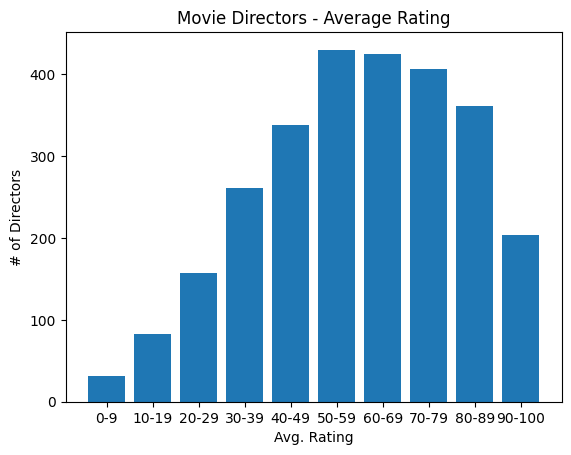

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nicholas.ayala\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\nicholas.ayala\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\nicholas.ayala\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\nicholas.ayala\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\nicholas.ayala\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nicholas.ayala\AppData\Roa

Tokenized sentences:
['0        percy jackson & the olympians: the lightning t...\n1        please give: nicole holofcener: kate catherine...\n2        10: blake edwards: a successful middle aged ho...\n3        12 angry men (twelve angry men): sidney lumet:...\n4        20,000 leagues under the sea: richard fleische...\n                               ...                        \n17172    zoolander 2: ben stiller: former models derek ...\n17173    zoom: peter hewitt: capt.', 'zoom or jack tim all...\n17174    zoot suit: luis valdez: mexican american gangs...\n17176    zulu: cy endfield, cyril endfield: in 1879 the...\n17177    zulu dawn: douglas hickox: sir henry bartle fr...\nlength: 11141, dtype: object']

Tokenized words:
[['0', 'percy', 'jackson', '&', 'the', 'olympians', ':', 'the', 'lightning', 't', '...', '1', 'please', 'give', ':', 'nicole', 'holofcener', ':', 'kate', 'catherine', '...', '2', '10', ':', 'blake', 'edwards', ':', 'a', 'successful', 'middle', 'aged', 'ho', '...', 

In [2]:
##############################################################################################################
# PHASE 2 - PART 1 Análisis Exploratorio de Datos (EDA) ######################################################
##############################################################################################################
# Clean up the data for processing
columns = ['movie_title','movie_info', 'genres', 'directors', 'tomatometer_rating']
df = tools.clean_dataset(columns, df)
directorDf = df

# Get the amount of times a Director appears in the dataset
directorCountDf = directorDf.directors.value_counts().reset_index().rename(columns={"index": "value", 0: "count"})

# Get the amount of directors that appear only once and drop them from directorDf, else get the average rating for each director
for row in directorCountDf.index:
    if directorCountDf['count'][row] <= 1:
        director = directorCountDf['directors'][row]
        directorDf.drop(directorDf[directorDf['directors'] == director].index, inplace=True, axis=0)
        
# Get the average rating for each director that is still in the dataframe
avgRating = tools.get_avg_rating(directorDf)
avgRating.tomatometer_rating = avgRating.tomatometer_rating.round(1)

#Drop directors who have an average rating of 0
for index, row in avgRating.iterrows():
    if (row.tomatometer_rating == 0.0):
        avgRating.drop(avgRating[avgRating.tomatometer_rating == 0.0].index, inplace=True, axis=0)
        
# Lets show a plot to show the average ratings for the director(s)
# Lets begin by creating some buckets divisible by 10
bucket0, bucket10, bucket20, bucket30, bucket40, bucket50, bucket60, bucket70, bucket80, bucket90 = ([] for i in range(10))

for index, row in avgRating.iterrows():
    director = row['directors']
    if row['tomatometer_rating'] < 10:
        bucket0.append(director)
    elif (row['tomatometer_rating'] >= 10) & (row['tomatometer_rating'] < 20):
        bucket10.append(director)
    elif (row['tomatometer_rating'] >= 20) & (row['tomatometer_rating'] < 30):
        bucket20.append(director)
    elif (row['tomatometer_rating'] >= 30) & (row['tomatometer_rating'] < 40):
        bucket30.append(director)
    elif (row['tomatometer_rating'] >= 40) & (row['tomatometer_rating'] < 50):
        bucket40.append(director)
    elif (row['tomatometer_rating'] >= 50) & (row['tomatometer_rating'] < 60):
        bucket50.append(director)
    elif (row['tomatometer_rating'] >= 60) & (row['tomatometer_rating'] < 70):
        bucket60.append(director)
    elif (row['tomatometer_rating'] >= 70) & (row['tomatometer_rating'] < 80):
        bucket70.append(director)
    elif (row['tomatometer_rating'] >= 80) & (row['tomatometer_rating'] < 90):
        bucket80.append(director)
    elif (row['tomatometer_rating'] >= 90) & (row['tomatometer_rating'] <= 100):
        bucket90.append(director)
        
# Create a bar graph using the buckets that have been created above.
# Use the count of how many directors belong to each bucket.
x = np.array(["0-9", "10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "70-79", "80-89", "90-100"])
y = np.array([len(bucket0), len(bucket10), len(bucket20), len(bucket30), len(bucket40), len(bucket50), len(bucket60), len(bucket70), len(bucket80), len(bucket90)])

# Construct the bar graph
plt.title("Movie Directors - Average Rating")
plt.xlabel("Avg. Rating")
plt.ylabel("# of Directors")
plt.bar(x, y)
plt.show()

##############################################################################################################
# PHASE 2 - PART 2 Procesamiento del Lenguaje Natural (NLP) ##################################################
##############################################################################################################
# We will begin by adding a SUMMARY column to our dataframe df that will combine all of the information except genre and rating since that will be for the metadata in AstraDB
df['summary'] = str(df['movie_title'].astype(str) + ": " + df['directors'].astype(str) + ": " + df['movie_info'].astype(str)).lower()

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('wordnet')
nltk.download('stopwords')
stopWords = set(stopwords.words('english'))
# Tokenize the each line into sentences and then words
for index, text in enumerate(df['summary']):
        sentences = sent_tokenize(text)
        words = [word_tokenize(sentence) for sentence in sentences]
        tagsPos = [pos_tag(word) for word in words]
        
        lemmatizer = WordNetLemmatizer()
        lems = [[lemmatizer.lemmatize(_word) for _word, tag in word] for word in tagsPos]
        
        sa = SentimentIntensityAnalyzer()
        sentiments = [sa.polarity_scores(sentence) for sentence in sentences]
        
        entities = [ne_chunk(pos_tag(word_tokenize(sentence))) for sentence in sentences]
        
# Imprimir resultados
print("Tokenized sentences:")
print(sentences)
print("\nTokenized words:")
print(words)
print("\nPOS Tags:")
print(tagsPos)
print("\nLems:")
print(lems)
print("\nSentiments Analisis:")
print(sentiments)
print("\nNERs:")
for entity in entities:
    print(entity)

In [6]:
##############################################################################################################
# PHASE 3 - PART 1 Generación y Análisis de Sentimientos #####################################################
##############################################################################################################
# Tokenize the sentences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
total_words = len(tokenizer.word_index) + 1

# Create input sequences
input_sequences = []
for line in sentences:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# Pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# Create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
label = ku.to_categorical(label, num_classes=total_words)

# Create the GAN
model = tf.keras.Sequential()
model.add(Embedding(input_dim=total_words, output_dim=10, input_length=max_sequence_len-1))
model.add(LSTM(150, return_sequences = True))
model.add(LSTM(100))
model.add(Dense(total_words, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(predictors, label, epochs=100, verbose=1)

ValueError: Unrecognized keyword arguments passed to Embedding: {'input_length': 54}

In [ ]:
# Load GAN model
gan_model = load_gan_model('path_to_gan_model')

# Generate synthetic reviews
noise = generate_random_noise(num_reviews)
synthetic_reviews = gan_model.generator(noise)

# Preprocess reviews for BERT
preprocessed_reviews = preprocess_reviews_for_bert(synthetic_reviews)

# Load BERT model
bert_model = load_bert_model('path_to_bert_model')

# Perform sentiment analysis
sentiment_scores = bert_model(preprocessed_reviews)

In [ ]:


model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Prepare the dataset for BERT
def convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN): 
  train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

  validation_InputExamples = test.apply(lambda x: InputExample(guid=None, 
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)
  
  return train_InputExamples, validation_InputExamples

def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )


DATA_COLUMN = 'text'
LABEL_COLUMN = 'sentiment'

# Assuming train and test are your dataframes and they have 'text' and 'sentiment' as their columns
train_InputExamples, validation_InputExamples = convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(32).repeat(2)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(32)

# Train the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

model.fit(train_data, epochs=2, validation_data=validation_data)
